In [1]:
%load_ext autoreload
%autoreload 2

import ast  # noqa: E402
import os  # noqa: E402
import sys  # noqa: E402
import time  # noqa: E402

import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402

sys.path.append("..")
os.environ["NLTK_DATA"] = "../data/nltk_data"

from backend.llm.chat import (  # noqa: E402
    prompt_difficulty,
    prompt_difficulty_by_llm,
    prompt_difficulty_by_llm_with_responses,
)
from backend.llm.constants import ChatProvider  # noqa: E402

In [2]:
df = pd.read_csv("~/data/lmsys/train.csv")


def str2list(s):
    try:
        return ast.literal_eval(s)[0]
    except Exception as _:
        return None


for col in ("response_a", "response_b", "prompt"):
    df[col] = df[col].apply(str2list)

df.head(2)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0


In [3]:
df_sample = df.sample(100, random_state=123)
df_sample.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
26237,1952415615,mpt-30b-chat,llama-2-70b-chat,"tell me about ""The Mysterious Affair at Styles...","""The Mysterious Affair at Styles"" is a work of...","""The Mysterious Affair at Styles"" is a novel b...",0,0,1
12450,922466919,mixtral-8x7b-instruct-v0.1,gpt-3.5-turbo-0613,explain about ladder 3 of causal AI in 6 sente...,"Sure, I'd be happy to explain ladder 3 of caus...",Ladder 3 of causal AI focuses on the identific...,1,0,0
26470,1969332395,mpt-7b-chat,chatglm-6b,hi can you teach me python oop?,Sure! I’d be happy to help you learn Python ob...,"Sure, I can help you with Python oop.\n\nPytho...",0,1,0
5828,438653093,openchat-3.5,gpt-4-1106-preview,I want to convert my static website into a bun...,"Yes, there are several comprehensive guides av...",Webpack is a powerful module bundler that can ...,1,0,0
25778,1918445911,gemini-pro-dev-api,wizardlm-70b,What is the gross salary under AEB funding rules?,"Under AEB funding rules, the gross salary is t...","I'm not familiar with the specific term ""AEB f...",0,0,1


In [35]:
def apply_prompt_difficulty(row: pd.Series):
    return prompt_difficulty(row.prompt, [row.response_a, row.response_b])


def apply_prompt_difficulty_llm(row: pd.Series):
    llm_out_no_responses = prompt_difficulty_by_llm(
        ChatProvider.OPENAI,
        "gpt-4o-mini",
        os.environ["OPENAI_API_KEY"],
        row.prompt,
    )
    llm_with_responses_out = prompt_difficulty_by_llm_with_responses(
        ChatProvider.OPENAI,
        "gpt-4o-mini",
        os.environ["OPENAI_API_KEY"],
        row.prompt,
        {"a": row.response_a, "b": row.response_b},
    )
    result = {}
    for llm_out, label in zip(
        (llm_out_no_responses, llm_with_responses_out),
        ("prompt_difficulty_by_llm", "prompt_difficulty_by_llm_with_responses"),
        strict=True,
    ):
        try:
            result[label] = float(llm_out.content)
        except Exception as _:
            print(label, llm_out.content)
            result[label] = None
    return result


print(time.strftime("%c"))
difficulty_df = df_sample.apply(apply_prompt_difficulty, axis=1, result_type="expand")
print(time.strftime("%c"))
difficulty_df_llm = df_sample.apply(apply_prompt_difficulty_llm, axis=1, result_type="expand")
print(time.strftime("%c"))
df_sample = pd.concat([difficulty_df_llm, difficulty_df, df_sample], axis=1)
df_sample.head()

Fri Aug  2 00:44:01 2024
Fri Aug  2 00:45:46 2024
Fri Aug  2 00:47:57 2024


,prompt_difficulty_by_llm,prompt_difficulty_by_llm_with_responses,prompt_difficulty,embedding_similarity,structure_similarity,content_similarity,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
26237,0.2,0.7,0.270779,0.866978,0.831926,0.230769,1952415615,mpt-30b-chat,llama-2-70b-chat,"tell me about ""The Mysterious Affair at Styles...","""The Mysterious Affair at Styles"" is a work of...","""The Mysterious Affair at Styles"" is a novel b...",0,0,1
12450,0.4,0.6,0.269599,0.906921,0.760879,0.243386,922466919,mixtral-8x7b-instruct-v0.1,gpt-3.5-turbo-0613,explain about ladder 3 of causal AI in 6 sente...,"Sure, I'd be happy to explain ladder 3 of caus...",Ladder 3 of causal AI focuses on the identific...,1,0,0
26470,0.3,0.6,0.433293,0.800131,0.492970,0.093750,1969332395,mpt-7b-chat,chatglm-6b,hi can you teach me python oop?,Sure! I’d be happy to help you learn Python ob...,"Sure, I can help you with Python oop.\n\nPytho...",0,1,0
5828,0.3,0.6,0.321922,0.873923,0.679623,0.186147,438653093,openchat-3.5,gpt-4-1106-preview,I want to convert my static website into a bun...,"Yes, there are several comprehensive guides av...",Webpack is a powerful module bundler that can ...,1,0,0
25778,0.3,0.7,0.424386,0.818138,0.476203,0.118421,1918445911,gemini-pro-dev-api,wizardlm-70b,What is the gross salary under AEB funding rules?,"Under AEB funding rules, the gross salary is t...","I'm not familiar with the specific term ""AEB f...",0,0,1


In [52]:
df_sample["prompt_difficulty_percentile"] = df_sample["prompt_difficulty"].rank(pct=True)
df_sample["difficulty_diff"] = (
    df_sample["prompt_difficulty_by_llm_with_responses"] - df_sample["prompt_difficulty_percentile"]
)
df_sample.to_csv("lmsys_sample_rated_for_difficulty.csv", index=False, encoding="utf-8", errors="replace")

In [37]:
# Calculate the percentile for prompt_difficulty
df_sample["prompt_difficulty_pct"] = df_sample["prompt_difficulty"].rank(pct=True) * 100

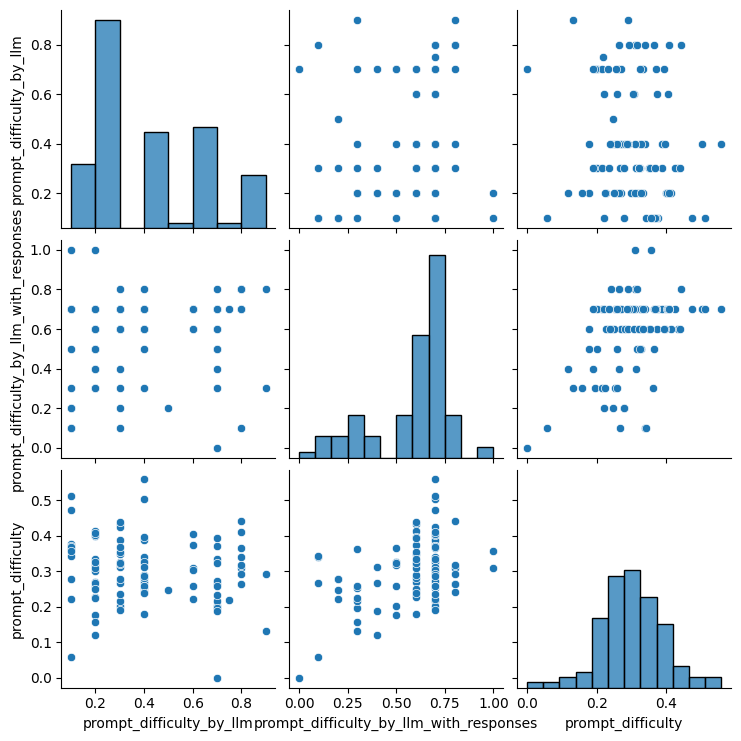

In [44]:
sns.pairplot(
    df_sample, vars=["prompt_difficulty_by_llm", "prompt_difficulty_by_llm_with_responses", "prompt_difficulty"]
)